# Linear Regression and Amazon Linear Learner Algorithm - Part 2

# Assumptions and Disclaimers
This blogpost assumes that you have already completed the following tutorials from Amazon SageMaker docuemntation:
- [Setting up](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-set-up.html)
- [Create am Amazon SageMaker Notebook Instance](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html)
- I have included 'sagemaker' in the name of my S3 bucket, "cyrusmv-sagemaker-demos' and have chosen to let any SageMaker notebook instance to access any S3 bucket with the term 'sagemaker' included in the name. This is however is not a recommended security option for production and is only useful for simplifying the flow of the blog.
- It is assumed that the reader is familiar with linear regression. If not please read part 1 of this post.



# Introduction

Surprisingly many problems in the real-world can be approximated to a linear problem, meaning that a function of degree one over a vector of parameters is a representation of the data. Linear regression is perhaps the most applied and simplest of all machine learning models.

With this in mind, we have implemented a scalable linear regression model as a part of Amazon Algorithms that can be used in SageMaker.

In part 1 of this post I intend to provide an easy and intuitive introduction to linear regression as well as providing references to implement your own linear regression, both from scratch and using MXNet and Gluon.

In part 2 we use the Visa Credit Card Fraud dataset from Kaggle, pre-process the data, and use Amazon LinearLearner to predict fraudulant transactions.

## An Introduction to Linear Regression
### The Theory:
Let us you have a dataset composed of descrete values scattered around in a way that a straight line can pass through them, which most of the data are within a certain distance from the line.

Remembering from high-school math, we now that in a two-dimential space a straight line can ber represented a function, formalized as:
$$f:\mathcal{D} \rightarrow \mathcal{R}$$
$$y = f(x) = ax + b$$
Now if $\mathcal{D}=\left\{0, 2, 3, ..., 49\right\}$, then for $a=2$ and $b=1$, $\mathcal{R}$ is all positive odd numbers that are less than $100$
Below we create such data and plot the function.


In [12]:
import numpy as np #a library for array operations
import matplotlib.pyplot as plt #Python 2D plotting library
range_start = 0
range_end = 49

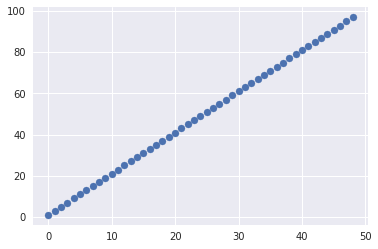

In [13]:
d = np.arange(range_start, range_end)
r = list(map(lambda x: 2 * x + 1, d)) #function y = 2x+1 for domain d, returning the range as a list
plt.scatter(d, r, )
plt.show()

**Adding Noide**
The problem is that the data in real life is noisy and almost never follows a perfect line. In many cases, however the distribution of data permits us to approximate the data to a line that represents the istribution with some error. Below we synthesize a dataset based on the same function, except that, the domain will be a random normal distribution with some random noise between 0 and 1.

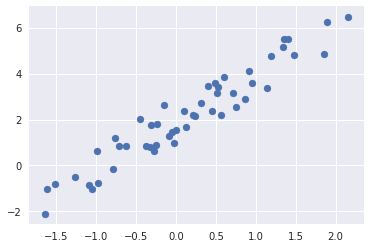

In [14]:
import random as rnd
noise_factor = 2
rnd.seed(42)
np.random.seed(13)
d = np.random.normal(loc=range_start, scale=1, size=range_end + 1)
r = list(map(lambda x: 2 * x + 1 + rnd.random()* noise_factor, d))
plt.scatter(d, r, )
plt.show()

We can still notive that we can use a stright line to which the data pattern can be approxmated. in a multi-dimentional world, where the function variable is a vector such as <age, income, postal district, ...>, our function would be:
$$f:{V} \subseteq \mathbb{R}^n  \rightarrow \mathcal{R} \subseteq \mathbb{R}
\\ 
y = f(V) = V.W + b
$$
in which V is the input feature vectord, w is a parameter or weight vector and b is bias. The task of linear regression is to find optimal w and b in order to approximate the data to a line.

In below plot we are using seaborn in order to find the appropriate line. The green line is in fact the optimal line.

Suppose we have a 4D input space $$V=\{inv_1=genter, v_2=age, v_3=education, v_4=postal_district\}$$ and would like to predect income. Since the range of the function is $\mathbb {R}$ and $V$ has a dimention of $1 \times 4$, we should find $W_{4 \times 1}$ and scalar $d$ to solve the linear regression problem.

$$
f: \mathbb{R^4} \rightarrow \mathbb{R} \\ 
f(V) = \left[\begin{array}{cc} v_1 & v_2 & v_3 & v_4 \end{array}\right]_{1 \times 4} \ 
\left[\begin{array}{cc} w_1\\ w_2\\ w_3\\ w_4 \end{array}\right]_{4 \times 1} \
+ d \ \epsilon \ \mathbb {R}  = y \ \epsilon \ \mathbb {R}
$$

In machine learning the input space is always multi-dimentional, but in our exaples and plots we have used 1D syntetic data in order to simplify the presentation.

*Challenge:* You can change shape and noise of the data and check the results.

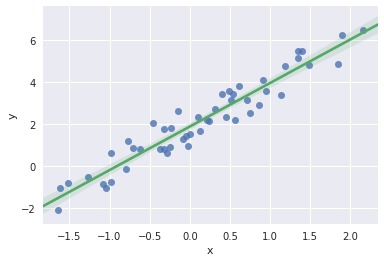

In [15]:
import seaborn as sns
import pandas as pd

noisy_data = pd.DataFrame(np.column_stack((d, r)), columns=['x', 'y'])
sns.set(color_codes=True)
sns.regplot('x', 'y', data=noisy_data, line_kws={'color': 'g'}, scatter_kws={'color':'b'})
plt.show()


In [16]:
print("in the perfect world f(d[5]) = f({}) = {}".format(d[5], 2*d[5]+1))
print("in the reality f(d[5]) = f({}) = {}".format(d[5], r[5]))


in the perfect world f(d[5]) = f(0.5323378882945463) = 2.064675776589093
in the reality f(d[5]) = f(0.5323378882945463) = 3.4180747514349155


## Model Error
in the perfect world f(d[5]) = f(0.5323378882945463) = __2.064675776589093__. 
in the reality f(d[5]) = f(0.5323378882945463) = **3.4180747514349155**.

The first number is passing a number to our linear function, calculating the results based on its formula and prnting the results. The delt between the two numbers is resulted from error in the model. As we approximated out datapoints to a line, we introduced a delta between actual position of a point and its projected position on the refression line.

This might look like loss of accuracy, but in fact this approximation is the sourced of generalization power of machine learning for as long as the error is within acceptable threshold.

There are many mehtods of calculting error. One of the most common for linear regression is MSE or Mean Squared Error.

![Model Error or Loss](https://github.com/zackchase/mxnet-the-straight-dope/raw/dc1822005027d63eb9a20cde1a6276c7714050f4/img/linear-regression.png)

*reference: https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter02_supervised-learning/linear-regression-scratch.ipynb*

We can observe in thed below diagram that every point has a distance to the line. MSE is averaring distances of all the datapoint to our regression lin or formally:

Assume that $N$ is the number of data points and $d_i$ is the euclidean distance of data point $p_i$ to the regression line $l$, then: 
$$
MSE = \frac{1}{n}\sum_{i=1}^{N}d_i
$$
if $y_i$ is the the observed value for a particular input $x_i$ and $\hat{y_i}$ is the predicted value, then their euclidean distance is calculated as:

$$
d^2 = (y_i - \hat{y_i})^2 \\
\therefore \\
\mathcal{L} = MSE = \frac{1}{n}\sum_{i=1}^{N}{(y_i - \hat{y_i})^2}
$$

RMSE is a varint of MSE and is very popular for calculation of model error:
$$
\mathcal{L} = RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{N}{(y_i - \hat{y_i})^2}}
$$

## An Example
A classic example of linear regression is survival score for a pssenger in Titanic's infamous maiden vouyage. Let us start with a simple example. A classic example of linear regression is survival score for a passenger in Titanic's infamous maiden voyage.  Titanic dataset in Kaggle has captured this data. for more information on the dataset please chekout [!this link](https://www.kaggle.com/c/titanic). 

Note that I have already uploaded titaic train.csv from the kaggle website onto an S3 bucket called 


In [17]:
#Downloading data files from S3 to the notebook instance
import boto3

bucket = 'cyrusmv-sagemaker-demos' 
protocol = 's3://'

#titanic dataset
titanic_train_prefix = 'titanic-kaggle/train.csv'
titanic_train_datafile = 'data/titanic_train.csv'


#Downloading the file to a local folder
client = boto3.client('s3')
with open(titanic_train_datafile, 'wb') as f:
    client.download_fileobj(bucket, titanic_train_prefix, f)
    
    


In [18]:
#Inspecting Data
df = pd.read_csv(titanic_train_datafile)
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


All columns, other than *surviced* are called *features*. The goal of regression task is to predict the *target* based on learning patterns from *features*. Column *surviced* is our target. 

The regression task predicts a probability of survival. In a binary predection, we use a threshold function to make a binary decision based on propability score. For example, using a step function to set the threshold.
$$ 
f(x) = \begin{cases} 
      1 & x\geqq 0.5, \\
      0 & x< 0.5 
   \end{cases}
$$
We can indeed change the threshold in order to tune the model.

We shall now depart from the Titanic example, because the data requires pre-processing. Pre-processing of data is a crucial task in developing machine learning models and requires a separate post. We now use the credit card data set from Kaggle, where data is pre-processed, meaning:
- All data is numeric
- All data is factorized, meaning that ranges are transformed to *"one-of-N* form.
- All data is normalized, meaning that the ranges have become comparable.

# Part 1: Preprocessing data
If you are intersted in learning about preprocessing data, you should start here, otherwise you could simply start from part 2, when we load the data from npy files.

In [8]:
#imports
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import sagemaker.amazon.common as smac
import os
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

In [9]:
bucket = 'cyrusmv-sagemaker-demos'     #replace this with your own bucket 
prefix = 'visa-kaggle/original.csv'    #replace this with your own file inside the bucket
protocol="s3://"
datafile = 'data/original.csv'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
role = get_execution_role()
print(role)

sagemaker_session = sagemaker.Session()

arn:aws:iam::475933981307:role/service-role/AmazonSageMaker-ExecutionRole-20180102T172706


### Data ingestion
1. Downloding file locally
2. Loading file into pandas for inspection
3. conversting data to numpy
4. shuffling the data
5. spliting data into test and training
6. breaking up each data set to data and label

In [10]:
#Downloading the file to a local folder
client = boto3.client('s3')
with open(datafile, 'wb') as f:
    client.download_fileobj(bucket, prefix, f)

In [11]:
# loading data into pandas for inspection

df = pd.read_csv(datafile)
df.head(5)

KeyboardInterrupt: 

In [ ]:
df['Class'].count()

In [ ]:
df[df['Class'] == 1]['Class'].count()

In [ ]:
#Converting Data Into Numpy

raw_data = df.as_matrix()
print(raw_data.shape)

In [ ]:
#Shuffling the data
np.random.seed(123)
np.random.shuffle(raw_data)
label = raw_data[:, -1]
data = raw_data[:, :-1]


In [ ]:
print("label_shape = {}; data_shape= {}".format(label.shape, data.shape))

In [ ]:
# There are very few fraudulant transactions in the dataset, so I am putting their indexes in an array
# to plot and ensure they are evenly distributed, so when I split the dataset into test and training 
# I don't end up with a dispropostionate distribution
t = []
for i in range(len(label)):
    if label[i] == 1:
        t.append(i)

In [ ]:
sns.distplot(t, kde=True, rug=True, hist=False)
plt.show()

In [ ]:
!ls data


In [ ]:
#Splitting data into validation and training and breaking dataset into data and label

#60%-40% training to validation
train_size = int(data.shape[0]*0.6)

train_data  = data[:train_size, :]
val_data = data[train_size:, :]

train_label = label[:train_size]
val_label = label[train_size:]

#Saving arrays for later use
np.save('data/processed/train/train_data.npy', train_data, allow_pickle=True)
np.save('data/processed/train/train_label.npy', train_label, allow_pickle=True)
np.save('data/processed/test/val_data.npy', val_data, allow_pickle=True)
np.save('data/processed/test/val_label.npy', val_label, allow_pickle=True)


print("training data shape= {}; training label shape = {} \nValidation data shape= {}; validation label shape = {}".format(train_data.shape, 
                                                                        train_label.shape,
                                                                        val_data.shape,
                                                                        val_label.shape))



In [ ]:
sagemaker_session.upload_data(path='data/processed/', bucket='cyrusmv-sagemaker-demos', key_prefix='visa-kaggle/data')


# Part 2: Training
In this part we load the data from pre-processed files and train the model.

In [ ]:
train_data = np.load('data/train_data.npy')
train_label = np.load('data/train_label.npy')

val_data = np.load('data/val_data.npy')
val_label = np.load('data/val_label.npy')

print("training data shape= {}; training label shape = {} \nValidation data shape= {}; validation label shape = {}".format(train_data.shape, 
                                                                        train_label.shape,
                                                                        val_data.shape,
                                                                        val_label.shape))
train_set = (train_data, train_label)
test_set = (val_data, val_label)


# Data Conversion
Amazon Algorithms support csv and recordio/protobuf. recordio is faster than CSV and specially in algorithms that deal with sparse matrices, CSV is not supported, so I just convert the data into recordio

In [ ]:
vectors = np.array([t.tolist() for t in train_set[0]]).astype('float32')
labels = np.array([t.tolist() for t in train_set[1]]).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

# Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [ ]:
key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [ ]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

# Training the model
At this point we are using an linear learner from amazon algorithms. Docker file containing the model is located in multiple regions. We tool the following steps
1. define containers
2. Create am Estimator object and pass the hyper-parameters as well as the model location to it.
3. run Estimator.fit to begin training the model

In [ ]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}

In [ ]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, #S3 role, so the notebook can read the data and upload the model
                                       train_instance_count=1, #number of instances for training
                                       train_instance_type='ml.p2.xlarge', # type of training instance
                                       output_path=output_location, #s3 location for uploading trained mdoel
                                       sagemaker_session=sess)

linear.set_hyperparameters(feature_dim=30, #dataset has 30 columns (features)
                           predictor_type='binary_classifier', # we predict a binary value. it could have been regressor
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

# Hosting the model
We use sagemaker to host the live model by calling deploy from estimator we defined previously. This action will create a dockerized environment using ECS and permits autoscaling. 

In [ ]:
linear_predictor = linear.deploy(initial_instance_count=1, #Initial number of instances. 
                                                           #Autoscaling can increase the number of instances.
                                 instance_type='ml.m4.xlarge') # instance type

# Prediction
deploy resturn a live endpoint (linear_predictor). Predictors in sagemaker accept csv and json. In this case we use json serialization.

In [ ]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [ ]:
#since score==1 is very rare we want to make sure we can correctly predict fradulant transaction. 
#First we print a lost of all labels where score == 1, then then run a prediction
t = []
for i in range(len(train_label)):
    if train_label[i] == 1:
        t.append(i)
        
print(t)
print(linear_predictor.predict(train_set[0][1294:1299]))


In [ ]:
non_zero = np.count_nonzero(test_set[1])
zero = len(test_set[1]) - non_zero
print("validation set includes: {} non zero and {} items woth value zero".format(non_zero, zero))

In [ ]:
predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [ ]:
import pandas as pd

pd.crosstab(test_set[1], predictions, rownames=['actuals'], colnames=['predictions'])

The confusion matrix above indicates that:
- of 162 fraudulant cases we detected 143 correcly
- 39 times a non-fraudulant transaction has been flagges as fraud from a total of 113761 transactions.


# (optional) Delete the endpoint
f you're ready to be done with this notebook, please run the delete_endpoint line in the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:



Let us start with a simple example. A classic example of linear regression is survival score for a pssenger in Titanic's infamous maiden vouyage. Let us start with a simple example. A classic example of linear regression is survival score for a passenger in Titanic's infamous maiden voyage.  Titanic dataset in Kaggle has captured this data. for more information on the dataset please chekout [!this link](https://www.kaggle.com/c/titanic). 